# Bacground
In cells, initiation of cell death can occur through two distinct apoptotic pathways - **intrinsic pathway** or **extrinsic pathway**. Extrinsic pathway is initiated by Fas death receptors (FasR). After Fas ligand (FasL) binding, the FasL/FasR complex would trimerize and form death inducing signaling complex (DISC). DISC would activate **Caspase 8**, then Caspase-8 is able to activate **Caspase 3**. At the same time, Caspase-8 can also regulate intrinsic pathway that happens at mitochondria by activating **BH3 interacting-domain death agonis (BID)**. BID is a pro-apoptotic rgeulator that could activate **Caspase-9**. Active Caspase-9 enhances Caspase-3 activation, 

In [ ]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

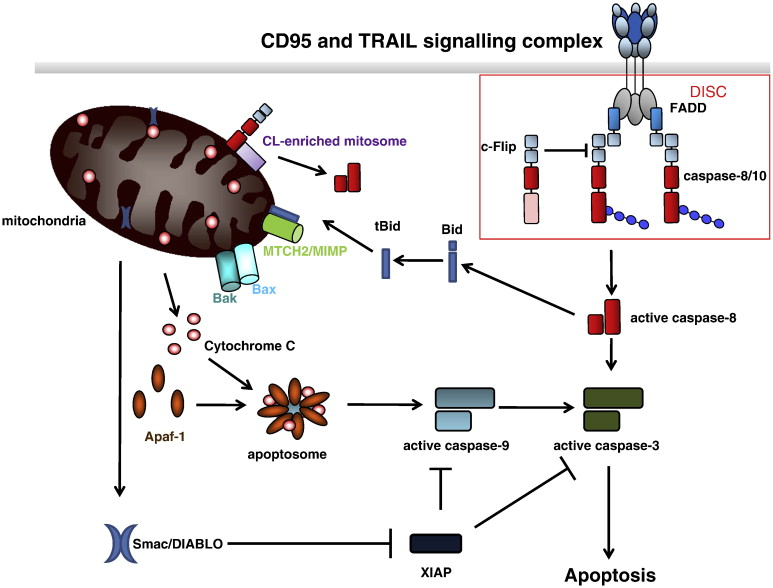

In [3]:
Image("cell death.jpg")

# Modeling of the Caspase Cascade with Positive Feedback

We will model the **extrinsic and intrinsic apoptotic pathways** with major players Caspase-8, Caspase-3, Bid, and Caspase-9:
1. Caspase-8 activation via FasL-FasR signaling
2. Bid cleavage and activation by Caspase-8
3. Caspase-9 activation via Bid
3. Caspase-3 activation by both Caspase-8 and Caspase-9

### **1. Caspase-8 Activation**
Caspase-8 is activated by FasL via a **Hill function**:
$$
\frac{dC_8}{dt} = k_1 \frac{[FasL]^n}{K_d^n + [FasL]^n} - k_2 C_8
$$
- $ C_8 $ = Concentration of active Caspase-8
- $ k_1 $ = Rate of Caspase-8 activation
- $ k_2 $ = Degradation rate of Caspase-8
- $ FasL $ = Death ligand concentration
- $ K_d $ = Dissociation constant
- $ n $ = Hill coefficient
### **2. Bid Cleavage and Activation**
Caspase-8 activates **Bid**, which promotes Caspase-9 activation:
$$
\frac{dB}{dt} = k_3 C_8 - k_4 B
$$
- $ B $ = Concentration of active Bid
- $ k_3 $ = Rate of Bid cleavage by Caspase-8
- $ k_4 $ = Degradation rate of Bid

### **3. Caspase-9 Activation**
Caspase-9 is activated by **Bid**:
$$
\frac{dC_9}{dt} = k_5 B - k_6 C_9
$$
- $ C_9 $ = Concentration of active Caspase-9
- $ k_5 $ = Rate of Caspase-9 activation by Bid
- $ k_6 $ = Degradation rate of Caspase-9

### **4. Caspase-3 Activation**
Caspase-3 is activated by both **Caspase-8 and Caspase-9**:
$$
\frac{dC_3}{dt} = k_7 C_8 + k_8 C_9^m - k_9 C_3
$$
- $ C_3 $ = Concentration of active Caspase-3
- $ k_7 $ = Activation rate of Caspase-3 by Caspase-8 
- $ k_8 $ = Activation rate of Caspase-3 by Caspase-9
- $ k_9 $ = Degradation rate of Caspase-3
- $ m $ = Hill coefficient



### **Table: Rate Constants Used in the Our Model**

$$
\begin{array}{|c|c|l|}
\hline
\textbf{Parameter} & \textbf{Value} & \textbf{Description} \\
\hline
k_1 & 1.0\times 10^{-4}\,\mathrm{nM}^{-1}\mathrm{s}^{-1} & \text{Caspase-8 activation rate} \\
k_2 & 6.5\times 10^{-5}\,\mathrm{s}^{-1} & \text{Caspase-8 degradation rate} \\
k_3 & 5.0\times 10^{-4}\,\mathrm{nM}^{-1}\mathrm{s}^{-1} & \text{Bid activation rate} \\
k_4 & 1.667\times 10^{-5}\,\mathrm{s}^{-1} & \text{Bid degradation rate} \\
k_5 & 2.0\times 10^{-4}\,\mathrm{nM}^{-1}\mathrm{s}^{-1} & \text{Caspase-9 activation rate} \\
k_6 & 6.5\times 10^{-5}\,\mathrm{s}^{-1} & \text{Caspase-9 degradation rate} \\
k_7 & 5.8\times 10^{-4}\,\mathrm{nM}^{-1}\mathrm{s}^{-1} & \text{Caspase-3 activation by Caspase-8} \\
k_8 & 5.0\times 10^{-5}\,\mathrm{nM}^{-1}\mathrm{s}^{-1} & \text{Caspase-3 activation by Caspase-9 (positive feedback)} \\
k_9 & 9.667\times 10^{-5}\,\mathrm{s}^{-1} & \text{Caspase-3 degradation rate} \\
K_d & 1.032\,\mathrm{nM} & \text{Dissociation constant for Caspase-8 activation} \\
n   & 2 & \text{Hill coefficient for Caspase-8 activation} \\
m   & 2 & \text{Hill coefficient for positive feedback from Caspase-9} \\
\hline
\end{array}
$$



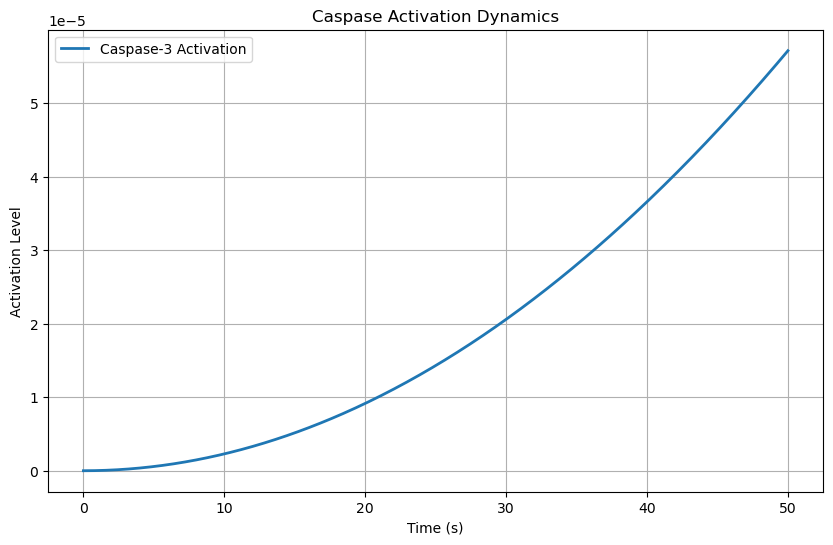

In [18]:
# Here we define the ODEs
def caspase_cascade_ode(y, t, k1, k2, k3, k4, k5, k6, k7, k8, k9, Kd, n, m, FasL):
    C8, B, C9, C3 = y

    # Caspase-8 activation 
    dC8_dt = k1 * (FasL**n) / (Kd**n + FasL**n) - k2 * C8

    # Bid cleavage and activation
    dB_dt = k3 * C8 - k4 * B

    # Caspase-9 activation 
    dC9_dt = k5 * B - k6 * C9

    # Caspase-3 activation 
    dC3_dt = k7 * C8 + k8 * (C9**m) - k9 * C3

    return [dC8_dt, dB_dt, dC9_dt, dC3_dt]

# Here we define parameters
params = {
    "k1": 1.0e-4,   
    "k2": 6.5e-5,   
    "k3": 5.0e-4,   
    "k4": 1.667e-5,   
    "k5": 2.0e-4,   
    "k6": 6.5e-5,   
    "k7": 5.8e-4,   
    "k8": 5.0e-5,  
    "k9": 9.667e-5,  
    "Kd": 1.032,  
    "n": 2,      
    "m": 2,      
}


y0 = [0, 0, 0, 0]

# Here we define simulation time
t = np.linspace(0, 50, 500) 

FasL = 2.0  # FasL level 
sol = odeint(caspase_cascade_ode, y0, t, args=(
    params["k1"], params["k2"], params["k3"], params["k4"], params["k5"], params["k6"],
    params["k7"], params["k8"], params["k9"], params["Kd"], params["n"], params["m"], FasL))

plt.figure(figsize=(10, 6))
plt.plot(t, sol[:, 3], label="Caspase-3 Activation", linestyle='-', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Activation Level")
plt.title("Caspase Activation Dynamics")
plt.legend()
plt.grid()
plt.show()

